# 1. Importing libraries

In [256]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import time
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import json
import pprint
import re

# 2. Loading the cleaned dataset

In [257]:
df = pd.read_csv('cleaned_dataset.csv',index_col=0)
print (df.shape)
df.head()

(205394, 27)


,Longitude,Latitude,Status,Address Type,Severity Description,Collision Type,Number of People Involved,Number of Pedestrians Involved,Number of Bicycles Involved,Number of Vehicles Involved,...,Weather,Road Condition,Light Condition,STATE Collision Description,Hit Parked Car,Year,Month,Date,Hour,Minute
0,-122.292141,47.536087,Matched,Block,Property Damage Only Collision,Sideswipe,2,0,0,2,...,Raining,Wet,Daylight,From same direction - both going straight - bo...,N,2018,12,12,15,49
1,-122.335422,47.598752,Matched,Block,Property Damage Only Collision,Other,1,0,0,1,...,Raining,Wet,Dark - Street Lights On,Fixed object,N,2018,12,16,2,44
2,-122.331579,47.598746,Matched,Block,Property Damage Only Collision,Sideswipe,2,0,0,2,...,Overcast,Dry,Daylight,From same direction - both going straight - bo...,N,2018,12,17,13,26
3,-122.334188,47.571578,Matched,Block,Property Damage Only Collision,Other,2,0,0,1,...,Raining,Wet,Dark - Street Lights On,Fixed object,N,2018,12,20,2,25
5,-122.337348,47.520472,Matched,Block,Injury Collision,Sideswipe,2,0,0,2,...,Clear or Partly Cloudy,Dry,Dark - Street Lights On,From same direction - both going straight - bo...,N,2018,12,14,17,33


# 3. Adding *Neighborhood* variable

### Installing *reverse_geocoder* library: The library takes in the latitude and longitude of a location as arguments and returns address type information such as *neighborhood*, *county*, *city* and *country*. 

In [1]:
#Installing and importing the reverse_geocoder library which converts coordinates to addresses
#!pip install reverse_geocoder

In [5]:
import reverse_geocoder as rg

### Collecting addresses from latitude and longitude data

In [ ]:
start = time.time()
try:
    df['Neighborhood'] = df.loc[:,['Latitude','Longitude']].iloc[687,:].apply(lambda x: rg.search((x[0],x[1]))[0]['name'],axis='columns')
except:
    print ("Error during neighborhood retrieval")
print (time.time()-start)

Above is an example for extracting neighborhood information using coordinates. Below, a snippet of the extracted coordinates are shown. 

In [12]:
df['Neighborhood'].value_counts()

Seattle                63913
Shoreline              13492
White Center           10817
Lake Forest Park        2961
Bryn Mawr-Skyway        2511
Riverton                2164
Mercer Island           1850
Boulevard Park           842
Inglewood-Finn Hill      800
Yarrow Point             392
Medina                   230
Tukwila                   28
Name: Neighborhood, dtype: int64

Exporting the neighborhood variable

In [ ]:
#df['Neighborhood'].to_csv('Neighborhood_variable.csv')

In [12]:
#Importing cleaned dataset with neighborhood variable added
#df.to_csv("Cleaned_data_with_neighborhood_variable.csv")

# 4. Adding *Speed* and *Road Class* variables using the *tomtom* API

Defining functions below in order to automate the retrieval of free flow speed and road type data using the *Tomtom API*, and also extracting traffic congestion plus road length data using the *Traffic API* from *HERE.com* 

In [241]:
def get_speed(lat,lon):
    url = 'https://api.tomtom.com/traffic/services/4/flowSegmentData/absolute/10/xml?key=bCvOmybucnuOOwZCNZIiakuB9mWP6AAg&point='+str(lat)+','+str(lon)
    r = requests.get(url)
    c = r.content
    soup = BeautifulSoup(c)
    point = soup.find_all('freeflowspeed')
    if len(point) == 1:
        return (point[0].text)
    else:
        return np.nan
    
def get_road(lat,lon):
    url = 'https://api.tomtom.com/traffic/services/4/flowSegmentData/absolute/10/xml?key=bCvOmybucnuOOwZCNZIiakuB9mWP6AAg&point='+str(lat)+','+str(lon)
    r = requests.get(url)
    c = r.content
    soup = BeautifulSoup(c)
    point = soup.find_all('frc')
    if len(point) == 1:
        return (point[0].text)
    else:
        return np.nan

def get_here(lat,lon):
    url = 'https://traffic.api.here.com/traffic/6.1/flow.json?prox='+str(lat)+'%2C'+str(lon)+'%2C100&app_id=ZcPmh3qkaqe8UolMckOK&app_code=eIBFxxngmjKt76AjVOM9SA'
    r = requests.get(url)
    response = re.findall('\d\d\d',str(r))
    if (int(response[0]))!=200:
        return 999,999
    else:
        here_data = r.json()
        jam = here_data['RWS'][0]['RW'][0]['FIS'][0]['FI'][0]['CF'][0]['JF']
        length = here_data['RWS'][0]['RW'][0]['FIS'][0]['FI'][0]['TMC']['LE']
        return jam,length
    

The commands for extracting the speed, road length and road congestion data is shown below. They are commented out since the allowable API transactions for this data is limited. This data was extracted in subsets done over perdiods of several hours to ensure that the data was being extracted properly without any errors. 

Noticed that oftentimes an empty list would be returned when a certain speed value was not found using the *tomtom* API. According to the API, this error sometimes happens if the coordinates provided are too far from any known roads. 

In order to overcome this error, we included a condition inside the *get_speed()* function which checks whether the returned *freeflowspeed* value has a length of 0 or 1. If the length is 0 that indicates an error, in which case we simply return a null value. 

For the road variables from HERE, we checked whether the API response code was 200 (successful) otherwise, we would catch the error and manually include a value of 999 for those instances in order to prevent disruption of the automated API calling process. The 999 values were later filtered as outliers. 

In [ ]:
#speed = df[['Latitude','Longitude']].iloc[100000:205394,:].apply(lambda x: get_speed(x[0],x[1]),axis=1)
#road = df[['Latitude','Longitude']].iloc[:50000,:].apply(lambda x: get_road(x[0],x[1]),axis=1)

In [19]:
speed = pd.Series(speed)
speed.head()
speed.shape

(105394,)

Exporting speed variable

In [20]:
#speed.to_csv('Speed_variable_100000_to_205394.csv')

## 5. Concatenating the *Speed* lists and adding combined variable to main dataset

In [259]:
import glob

In [265]:
glob.glob("speed_data_files/*.csv")

['speed_data_files/Speed_variable_17500_to_30000.csv',
 'speed_data_files/Speed_variable_5000_to_7500.csv',
 'speed_data_files/Speed_variable_12500_to_15000.csv',
 'speed_data_files/Speed_variable_30000_to_100000.csv',
 'speed_data_files/Speed_variable_2500_to_5000.csv',
 'speed_data_files/Speed_variable_7500_to_10000.csv',
 'speed_data_files/Speed_variable_0_to_1000.csv',
 'speed_data_files/Speed_variable_10000_to_12500.csv',
 'speed_data_files/Speed_variable_100000_to_205394.csv',
 'speed_data_files/Speed_variable_1000_to_2500.csv',
 'speed_data_files/Speed_variable_15000_to_17500.csv',
 'speed_data_files/Speed_variable_0_to_999.csv']

In [266]:
#Reading all the speed data into dataframes
df1 = pd.read_csv("speed_data_files/Speed_variable_0_to_999.csv",header=None,index_col=0)
df2 = pd.read_csv("speed_data_files/Speed_variable_1000_to_2500.csv",header=None,index_col=0)
df3 = pd.read_csv("speed_data_files/Speed_variable_2500_to_5000.csv",header=None,index_col=0)
df4 = pd.read_csv("speed_data_files/Speed_variable_5000_to_7500.csv",header=None,index_col=0)
df5 = pd.read_csv("speed_data_files/Speed_variable_7500_to_10000.csv",header=None,index_col=0)
df6 = pd.read_csv("speed_data_files/Speed_variable_10000_to_12500.csv",header=None,index_col=0)
df7 = pd.read_csv("speed_data_files/Speed_variable_12500_to_15000.csv",header=None,index_col=0)
df8 = pd.read_csv("speed_data_files/Speed_variable_15000_to_17500.csv",header=None,index_col=0)
df9 = pd.read_csv("speed_data_files/Speed_variable_17500_to_30000.csv",header=None,index_col=0)
df10 = pd.read_csv("speed_data_files/Speed_variable_30000_to_100000.csv",header=None,index_col=0)
df11 = pd.read_csv("speed_data_files/Speed_variable_100000_to_205394.csv",header=None,index_col=0)

In [269]:
#df_speed = df1[29].append(df2[1]).append(df3).append(df4).append(df5).append(df6).append(df7).append(df8)
speed_combined = df1.append(df2).append(df3).append(df4).append(df5).append(df6).append(df7).append(df8).append(df9).append(df10).append(df11)

In [270]:
print (speed_combined.shape)

(205394, 1)


In [275]:
speed_combined.head()

,1
0,
0,48.0
1,85.0
2,13.0
3,58.0
5,55.0


In [276]:
df['Speed'] = speed_combined

In [182]:
df_speed['Speed'] = speed_combined

## 6. Retrieving traffic congestion and road length data

Using the HERE API to retrieve traffic congestion data in the form of a *jam factor* whose value ranges from 0 to 10 where a 10 indicates the highest congestion while a 0 indicates no congestion. 

We are also retreiving the road length information for the given route. Once again, the procedure below for making the API calls is commented out due to the limited API calls that can be made. 

In [ ]:
#jam_len = df[['Latitude','Longitude']].iloc[100000:205394,:].apply(lambda x: get_here(x[0],x[1]),axis=1)
#jam_len.shape

In [244]:
jam_len = list(zip(*jam_len))

In [245]:
congestion = pd.Series(list(jam_len[0]))
road_length = pd.Series(list(jam_len[1]))
print (len(congestion),len(road_length))

105394 105394


In [246]:
df['Traffic Congestion'] = congestion 
df['Road Length'] = road_length

Doing some initial analysis for the road length and congestion variables

In [250]:
#df_filtered = df[(df['Traffic Congestion']<900) & (df['Traffic Congestion']>-1) ]
df_filtered = df[(df['Traffic Congestion']<900)]

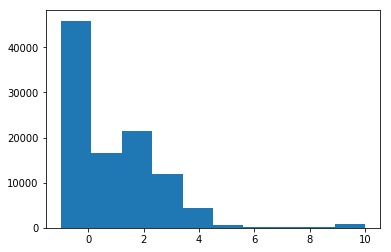

In [251]:
plt.hist(df_filtered['Traffic Congestion'])
plt.show()

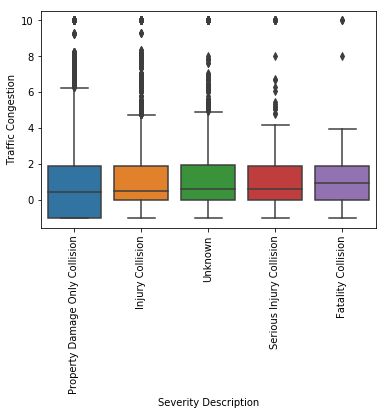

In [252]:
sns.boxplot(x='Severity Description',y='Traffic Congestion',data=df_filtered)
plt.xticks(rotation=90)
plt.show()

In [253]:
df_filtered[['Severity Description','Traffic Congestion']].groupby(['Severity Description']).agg(['count','mean','median','min','max'])

Traffic Congestion                           \
                                            count      mean    median  min   
Severity Description                                                         
Fatality Collision                            169  1.121939  0.955770 -1.0   
Injury Collision                            27202  0.851570  0.493610 -1.0   
Property Damage Only Collision              66048  0.849586  0.483350 -1.0   
Serious Injury Collision                     1538  0.887626  0.608475 -1.0   
Unknown                                      6941  0.926961  0.635920 -1.0   

                                      
                                 max  
Severity Description                  
Fatality Collision              10.0  
Injury Collision                10.0  
Property Damage Only Collision  10.0  
Serious Injury Collision        10.0  
Unknown                         10.0

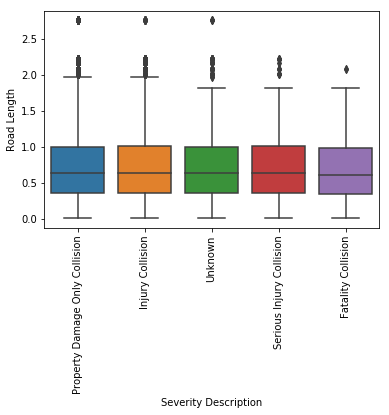

In [232]:
sns.boxplot(x='Severity Description',y='Road Length',data=df_filtered)
plt.xticks(rotation=90)
plt.show()

In [233]:
df_filtered[['Severity Description','Road Length']].groupby(['Severity Description']).agg(['count','mean','median','min','max'])

Road Length                              \
                                     count      mean   median      min   
Severity Description                                                     
Fatality Collision                     159  0.705890  0.61153  0.01262   
Injury Collision                     25799  0.719657  0.64112  0.00981   
Property Damage Only Collision       62800  0.718704  0.63599  0.00981   
Serious Injury Collision              1458  0.723935  0.64112  0.01036   
Unknown                               6469  0.716565  0.63599  0.00981   

                                         
                                    max  
Severity Description                     
Fatality Collision              2.07470  
Injury Collision                2.75415  
Property Damage Only Collision  2.75415  
Serious Injury Collision        2.22400  
Unknown                         2.75415

Exporting the road congestion and road length data to CSV files

In [254]:
congestion.to_csv('Congestion_variable_100000_to_205934.csv')
road_length.to_csv('Road_length_variable_100000_to_205934.csv')

In [289]:
#Reading in the traffic congestion and road length variables
df_cong_1 = pd.read_csv("Congestion_variable_0_to_100000.csv",header=None,index_col=0)
df_cong_2 = pd.read_csv("Congestion_variable_100000_to_205934.csv",header=None,index_col=0)
df_road_len_1 = pd.read_csv("Road_length_variable_0_to_100000.csv",header=None,index_col=0)
df_road_len_2 = pd.read_csv("Road_length_variable_100000_to_205934.csv",header=None,index_col=0)

In [294]:
#Combining congestion and road length variables
df_cong = df_cong_1.append(df_cong_2)
df_road_len = df_road_len_1.append(df_road_len_2)
print (df_cong.head())
print (df_cong.shape)
print (df_road_len.head())
print (df_road_len.shape)

         1
0         
0  2.36674
1 -1.00000
2 -1.00000
3  0.00000
4  1.57819
(205394, 1)
         1
0         
0  0.56104
1  0.36276
2  0.36276
3  1.73291
4  0.74738
(205394, 1)


## 7. Adding the road length and congestion variables to the original cleaned dataset. 

In [307]:
#Adding variables to original dataset
df['Road Congestion'] = list(df_cong[1])
df['Road Length'] = list(df_road_len[1])

In [308]:
df.head()

,Longitude,Latitude,Status,Address Type,Severity Description,Collision Type,Number of People Involved,Number of Pedestrians Involved,Number of Bicycles Involved,Number of Vehicles Involved,...,STATE Collision Description,Hit Parked Car,Year,Month,Date,Hour,Minute,Speed,Road Congestion,Road Length
0,-122.292141,47.536087,Matched,Block,Property Damage Only Collision,Sideswipe,2,0,0,2,...,From same direction - both going straight - bo...,N,2018,12,12,15,49,48.0,2.36674,0.56104
1,-122.335422,47.598752,Matched,Block,Property Damage Only Collision,Other,1,0,0,1,...,Fixed object,N,2018,12,16,2,44,85.0,-1.00000,0.36276
2,-122.331579,47.598746,Matched,Block,Property Damage Only Collision,Sideswipe,2,0,0,2,...,From same direction - both going straight - bo...,N,2018,12,17,13,26,13.0,-1.00000,0.36276
3,-122.334188,47.571578,Matched,Block,Property Damage Only Collision,Other,2,0,0,1,...,Fixed object,N,2018,12,20,2,25,58.0,0.00000,1.73291
5,-122.337348,47.520472,Matched,Block,Injury Collision,Sideswipe,2,0,0,2,...,From same direction - both going straight - bo...,N,2018,12,14,17,33,55.0,1.57819,0.74738


In [315]:
df.shape

(205394, 31)

In [316]:
df.columns

Index(['Longitude', 'Latitude', 'Status', 'Address Type',
       'Severity Description', 'Collision Type', 'Number of People Involved',
       'Number of Pedestrians Involved', 'Number of Bicycles Involved',
       'Number of Vehicles Involved', 'Number of Injuries',
       'Number of Serious Injuries', 'Number of Fatalities',
       'Incident Date and Time', 'Junction Type', 'SDOT Collision Description',
       'DUI', 'Weather', 'Road Condition', 'Light Condition',
       'STATE Collision Description', 'Hit Parked Car', 'Year', 'Month',
       'Date', 'Hour', 'Minute', 'Speed', 'Road Congestion', 'Road Length',
       'Neighborhood'],
      dtype='object')

Finally, exporting the entire dataset with the added variables for further analysis. 

In [317]:
df.to_csv('Cleaned_dataset_with_added_variables.csv')